In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import pickle
import cv2

from keras.utils import plot_model
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
os.makedirs('/kaggle/Data_Combined', exist_ok = True)
os.makedirs('/kaggle/Data_Combined/Glioma Tumor', exist_ok = True)
os.makedirs('/kaggle/Data_Combined/Meningioma Tumor', exist_ok = True)
os.makedirs('/kaggle/Data_Combined/Normal', exist_ok = True)
os.makedirs('/kaggle/Data_Combined/Pituitary Tumor', exist_ok = True)

In [4]:
shutil.copytree('/kaggle/input/brain-tumors-dataset/Data/Normal',
                '/kaggle/Data_Combined/Normal', dirs_exist_ok = True)
shutil.copytree('/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor',
                '/kaggle/Data_Combined/Glioma Tumor', dirs_exist_ok = True)
shutil.copytree('/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor',
                '/kaggle/Data_Combined/Meningioma Tumor', dirs_exist_ok = True)
shutil.copytree('/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor',
                '/kaggle/Data_Combined/Pituitary Tumor', dirs_exist_ok = True)

'/kaggle/Data_Combined/Pituitary Tumor'

In [5]:
aug_path = '/kaggle/Data_Combined'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

train_images = train_datagen.flow_from_directory(
    aug_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

validation_images = train_datagen.flow_from_directory(
    aug_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 18423 images belonging to 4 classes.
Found 3249 images belonging to 4 classes.


In [8]:
pretrained_model = tf.keras.applications.resnet.ResNet101(
    input_shape = (224, 224, 3), 
    include_top = False,
    weights = 'imagenet',
    classes = 4
)
pretrained_model.trainable = True

resnet_model = models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

171446536/171446536 [==============================] - 1s 0us/step


In [9]:
resnet_model.compile(optimizer = optimizers.Adam(),
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])

# Callback functions
model_es = EarlyStopping(monitor='val_accuracy', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=True)
model_cp = ModelCheckpoint('best_weights_resnet.h5', save_best_only=True, monitor='val_accuracy',
                           verbose=1)

# Training the model
history_resnet = resnet_model.fit(train_images,
                                  epochs = 50,
                                  validation_data = validation_images,
                                  callbacks = [model_es, model_rlr, model_cp])

pickle.dump(resnet_model, open('ResNet_Model_Tumor.pkl', 'wb'))

Epoch 1/50
576/576 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.8295
Epoch 1: val_accuracy improved from -inf to 0.39951, saving model to best_weights_resnet.h5
576/576 [==============================] - 424s 585ms/step - loss: 0.4823 - accuracy: 0.8295 - val_loss: 1.9504 - val_accuracy: 0.3995 - lr: 0.0010
Epoch 2/50
576/576 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9241
Epoch 2: val_accuracy improved from 0.39951 to 0.78209, saving model to best_weights_resnet.h5
576/576 [==============================] - 333s 578ms/step - loss: 0.2190 - accuracy: 0.9241 - val_loss: 0.9701 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 3/50
576/576 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9483
Epoch 3: val_accuracy improved from 0.78209 to 0.86334, saving model to best_weights_resnet.h5
576/576 [==============================] - 333s 577ms/step - loss: 0.1475 - accuracy: 0.9483 - val_loss: 0.4560 - val_accuracy: 0.8633

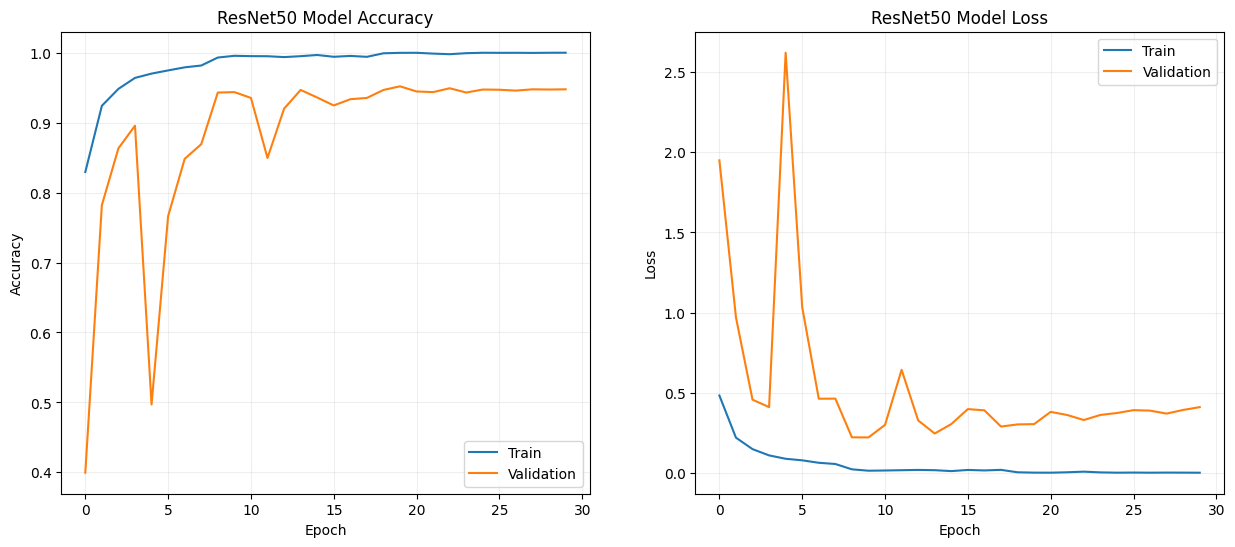

In [11]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_resnet.history['accuracy'])
ax[0].plot(history_resnet.history['val_accuracy'])
ax[0].set_title('ResNet50 Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha = 0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_resnet.history['loss'])
ax[1].plot(history_resnet.history['val_loss'])
ax[1].set_title('ResNet50 Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha = 0.2)

plt.show()

In [6]:
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape = (224, 224, 3), 
    include_top = False,
    weights = 'imagenet',
    classes = 4
)
pretrained_model.trainable = True

densenet_model = models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

74836368/74836368 [==============================] - 0s 0us/step


In [7]:
densenet_model.compile(optimizer = optimizers.Adam(),
                       loss = 'categorical_crossentropy',
                       metrics = ['accuracy'])

# Callback functions
model_es = EarlyStopping(monitor='val_accuracy', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=True)
model_cp = ModelCheckpoint('best_weights_densenet.h5', save_best_only=True, monitor='val_accuracy',
                          verbose=True)

# Training the model
history_densenet = densenet_model.fit(train_images,
                                      epochs = 50,
                                      validation_data = validation_images,
                                      callbacks = [model_es, model_rlr, model_cp])

pickle.dump(densenet_model, open('DenseNet_Model_Tumor.pkl', 'wb'))

Epoch 1/50
576/576 [==============================] - ETA: 0s - loss: 0.3571 - accuracy: 0.8741
Epoch 1: val_accuracy improved from -inf to 0.70606, saving model to best_weights_densenet.h5
576/576 [==============================] - 481s 584ms/step - loss: 0.3571 - accuracy: 0.8741 - val_loss: 0.9141 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 2/50
576/576 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9426
Epoch 2: val_accuracy improved from 0.70606 to 0.89474, saving model to best_weights_densenet.h5
576/576 [==============================] - 322s 559ms/step - loss: 0.1750 - accuracy: 0.9426 - val_loss: 0.2917 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 3/50
576/576 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9552
Epoch 3: val_accuracy did not improve from 0.89474
576/576 [==============================] - 320s 555ms/step - loss: 0.1339 - accuracy: 0.9552 - val_loss: 0.3481 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 4/50
576/576 [======

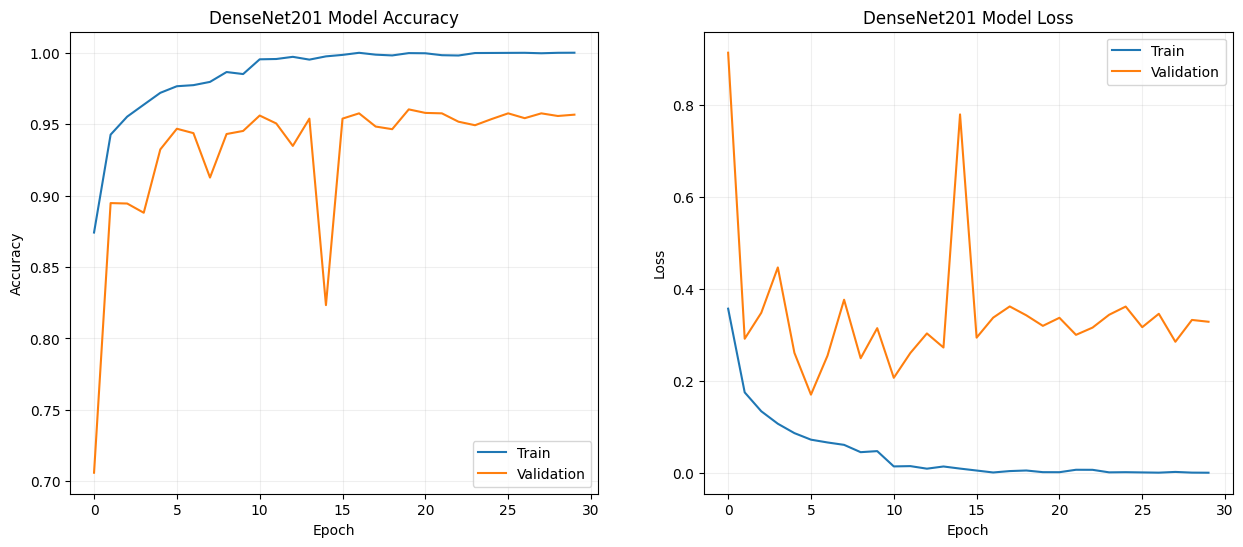

In [8]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_densenet.history['accuracy'])
ax[0].plot(history_densenet.history['val_accuracy'])
ax[0].set_title('DenseNet201 Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha = 0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_densenet.history['loss'])
ax[1].plot(history_densenet.history['val_loss'])
ax[1].set_title('DenseNet201 Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha = 0.2)

plt.show()

In [6]:
pretrained_model = tf.keras.applications.xception.Xception(
    input_shape = (224, 224, 3), 
    include_top = False,
    weights = 'imagenet',
    classes = 4
)
pretrained_model.trainable = True

xceptionnet_model = models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

83683744/83683744 [==============================] - 0s 0us/step


In [7]:
xceptionnet_model.compile(optimizer = optimizers.Adam(),
                       loss = 'categorical_crossentropy',
                       metrics = ['accuracy'])

# Callback functions
model_es = EarlyStopping(monitor='val_accuracy', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=True)
model_cp = ModelCheckpoint('best_weights_xceptionnet_tumor.h5', save_best_only=True, monitor='val_accuracy',
                           verbose=True)

# Training the model
history_xceptionnet = xceptionnet_model.fit(train_images,
                                            epochs = 50,
                                            validation_data = validation_images,
                                            callbacks = [model_es, model_rlr, model_cp])

pickle.dump(xceptionnet_model, open('XceptionNet_Model_Tumor.pkl', 'wb'))

Epoch 1/50
576/576 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8998
Epoch 1: val_accuracy improved from -inf to 0.91074, saving model to best_weights_xceptionnet_tumor.h5
576/576 [==============================] - 347s 529ms/step - loss: 0.2954 - accuracy: 0.8998 - val_loss: 0.2527 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 2/50
576/576 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9595
Epoch 2: val_accuracy improved from 0.91074 to 0.93044, saving model to best_weights_xceptionnet_tumor.h5
576/576 [==============================] - 319s 553ms/step - loss: 0.1198 - accuracy: 0.9595 - val_loss: 0.1895 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 3/50
576/576 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9768
Epoch 3: val_accuracy did not improve from 0.93044
576/576 [==============================] - 318s 552ms/step - loss: 0.0726 - accuracy: 0.9768 - val_loss: 0.2743 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 4/

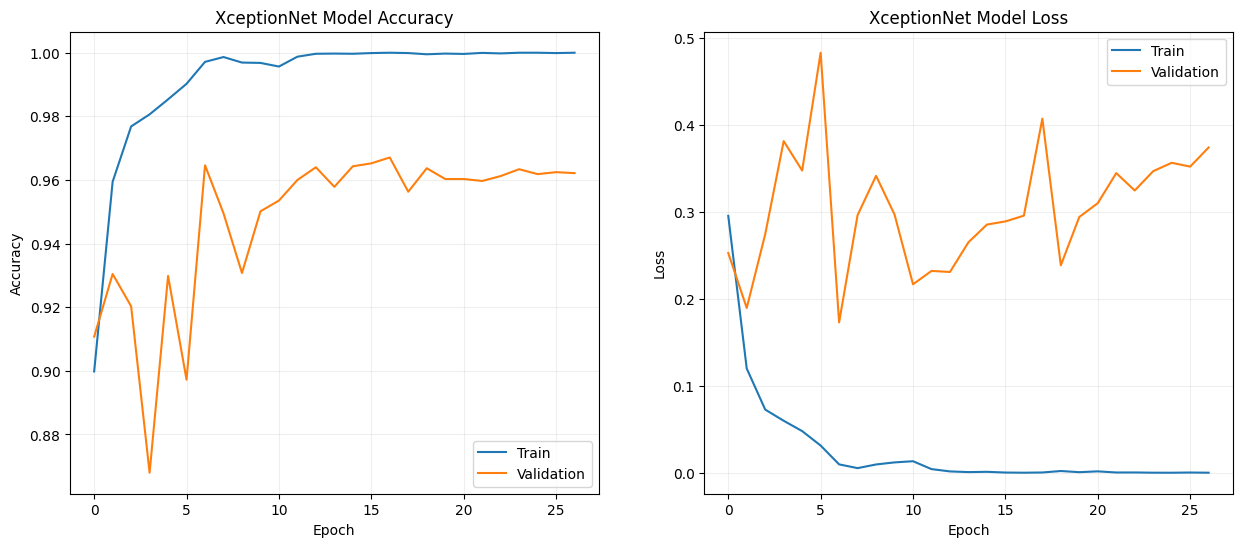

In [9]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_xceptionnet.history['accuracy'])
ax[0].plot(history_xceptionnet.history['val_accuracy'])
ax[0].set_title('XceptionNet Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha = 0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_xceptionnet.history['loss'])
ax[1].plot(history_xceptionnet.history['val_loss'])
ax[1].set_title('XceptionNet Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha = 0.2)

plt.show()

In [12]:
def baggingClassification(img, model1, model2):
    labels=["Glioma Tumor", "Meningioma Tumor", "Normal", "Pituitary Tumor"]
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32')
    img /= 255.0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((1, 224, 224, 3))
    prediction1 = model1.predict(img, verbose=0)
    prediction2 = model2.predict(img, verbose=0)
    prediction_list1 = prediction1[0].tolist()
    for label in range(len(prediction_list1)):
        prediction_list1[label] = float(prediction_list1[label])*100
    prediction_list2 = prediction2[0].tolist()
    for label in range(len(prediction_list2)):
        prediction_list2[label] = float(prediction_list2[label])*100
    predictions = []
    for idx in range(len(prediction_list1)):
        predictions.append(prediction_list1[idx]+prediction_list2[idx])
    labels_predictions = zip(labels, predictions)
    sorted_predictions = sorted(labels_predictions, reverse = True, key = lambda x : x[1])
    return sorted_predictions[0][0]

In [13]:
model1 = tf.keras.models.load_model('/kaggle/working/best_weights_xceptionnet_tumor.h5')
# model2 = tf.keras.models.load_model('/kaggle/working/best_weights_resnet.h5')
model2 = tf.keras.models.load_model('/kaggle/working/best_weights_densenet.h5')

correctly_classified_images = 0
total_images = 0

for img in validation_images.filepaths:
    total_images += 1
    prediction = baggingClassification(plt.imread(img), model1, model2)
    if('Glioma Tumor' in img and prediction == 'Glioma Tumor'):
        correctly_classified_images += 1
    elif('Meningioma Tumor' in img and prediction == 'Meningioma Tumor'):
        correctly_classified_images += 1
    elif('Normal' in img and prediction == 'Normal'):
        correctly_classified_images += 1
    elif('Pituitary Tumor' in img and prediction == 'Pituitary Tumor'):
        correctly_classified_images += 1
    
print("The number of correctly classified images out of a total of", total_images, "is", correctly_classified_images)
print("The percentage of correctly classified images is", correctly_classified_images*1.0/total_images)

The number of correctly classified images out of a total of 3249 is 3150
The percentage of correctly classified images is 0.9695290858725761


In [5]:
model1 = tf.keras.models.load_model(
    '/kaggle/input/cnn-model-for-brain-tumor-detection/best_weights_cnn_tumor.h5'
)
model2 = tf.keras.models.load_model('/kaggle/working/best_weights_resnet.h5')
model3 = tf.keras.models.load_model('/kaggle/working/best_weights_densenet.h5')

print("The given MRI image is classified as " + baggingClassification(
    plt.imread('/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor/G_100.jpg'),
    model1, model2, model3)
)

The given MRI image is classified as Glioma Tumor
